In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp  # Import TensorFlow Probability
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### standard sci-py libraries

import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

2023-08-08 10:44:28.721462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

In [14]:
hdl_mc = TreeHandler("/eos/user/h/hsharma/XicMLTrees/MC/XicSignal.root", "XicSignal")
hdl_data = TreeHandler("/eos/user/h/hsharma/XicMLTrees/DATA/XicBkg.root", "XicBkg")
hdl_bkg = hdl_data.apply_preselections("fM < 2.42 or fM > 2.5", inplace=False)
print('Size of samples \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))
print('----------------------------------')




# Samples for training
fractionData=0.005 # this is the fraction of total data used in training 
hdl_bkg.shuffle_data_frame(frac=fractionData, inplace=True)
print('Size of samples for training \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))


## now we remove the background from the data sample
hdl_data.apply_preselections("fM > 2.42 and fM < 2.5", inplace=True)



Size of samples 
Data =  308736 , MC =  2359
----------------------------------
Size of samples for training 
Data =  1544 , MC =  2359


In [15]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised', 
                'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1']


## some matplotlib tuning is needed to display all the features
# plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
#                       bins=30, labels=['Signal', 'Background'],
#                       log=1, density=True, figsize=(20, 20), alpha=0.3, grid=False);



In [16]:
# training_cols = ['fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised','fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
#                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1', 'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']

# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
training_cols = ['fCpa','fCpaXY',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1',
                 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                 'fChi2PCA',
                 'fRSecondaryVertex'
                 
                ]
# train_test_data is a combined dataset of data and MC
train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.5, random_state=42)

print('Size of train sample: ', len(train_test_data[0]))
print('Size of test sample: ', len(train_test_data[3]))


Size of train sample:  1951
Size of test sample:  1952


In [17]:
x_train=train_test_data[0][training_cols]
y_train=train_test_data[1]

x_test=train_test_data[2][training_cols]
y_test=train_test_data[3]

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [18]:
# Define a Bayesian Neural Network model using TensorFlow Probability
def build_bnn_model():
    model = tf.keras.Sequential([
        tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(80, activation='relu'),
        tfp.layers.DenseFlipout(1, activation='sigmoid')
    ])
    return model


In [19]:

# Create a custom scikit-learn estimator using TensorFlow and TFP
from sklearn.base import BaseEstimator, ClassifierMixin

class BayesianNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=100, batch_size=32, learning_rate=0.02):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = build_bnn_model()
    
    def fit(self, X, y):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        
        self.model.compile(loss=self.negative_log_likelihood, optimizer='adam')
        self.model.fit(X, y, epochs=self.n_epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y_pred = self.model(X).numpy()
        return (y_pred > 0.5).astype(int)
    
    def negative_log_likelihood(self, y_true, y_pred):
        return -tf.reduce_mean(self.log_likelihood(y_true, y_pred))
    
    def log_likelihood(self, y_true, y_pred):
        return tf.reduce_sum(
            tfp.distributions.Bernoulli(logits=y_pred).log_prob(y_true)
        )


In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameter search space
    n_epochs = trial.suggest_int('n_epochs', 10, 200)
    batch_size = trial.suggest_int('batch_size', 11, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    # Add more hyperparameters as needed

    # Split data into train and validation sets
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the BNN model
    bnn = BayesianNeuralNetwork(n_epochs=n_epochs, batch_size=batch_size, learning_rate=learning_rate)
    bnn.fit(x_train, y_train)

    # Make predictions on the validation set
    y_val_pred = bnn.predict(x_test)

    # Calculate accuracy for the validation set
    accuracy = accuracy_score(y_test, y_val_pred)

    return -accuracy  # Negative because optuna minimizes the objective

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-08-07 20:17:24,854] A new study created in memory with name: no-name-e6d0734e-5ca7-4820-95bf-4b0f54b813bd
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
[I 2023-08-07 20:17:56,725] Trial 0 finished with value: -0.6876613319566339 and parameters: {'n_epochs': 163, 'batch_size': 151, 'learning_rate': 0.09409218328179011}. Best is trial 0 with value: -0.6876613319566339.
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
[I 2023-08-07 20:18:52,807] Trial 1 finished with value: -0.4975047324040613 and parameters: {'n_epochs': 159, 'batch_size': 52, 'learning_rate': 0.09872120846336722}. Best is tria

In [38]:
n_epochs=32
batch_size=155
learning_rate=0.1
bnn = BayesianNeuralNetwork(n_epochs=n_epochs,batch_size=batch_size,learning_rate=learning_rate)

In [39]:
bnn.fit(x_train, y_train)

`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.


BayesianNeuralNetwork(batch_size=155, learning_rate=0.1, n_epochs=32)

In [40]:
score_test = bnn.predict(train_test_data[2][training_cols])


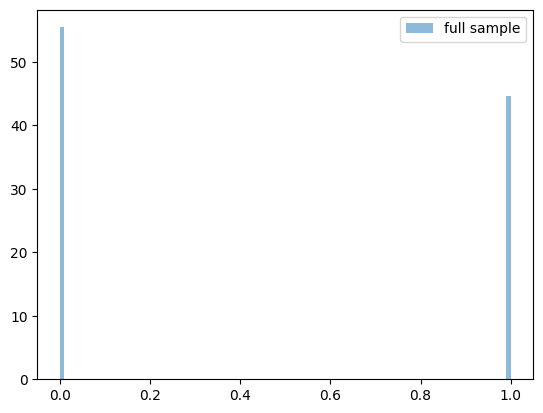

In [41]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

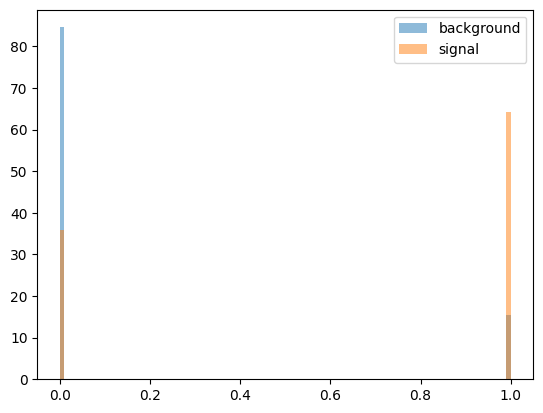

In [42]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


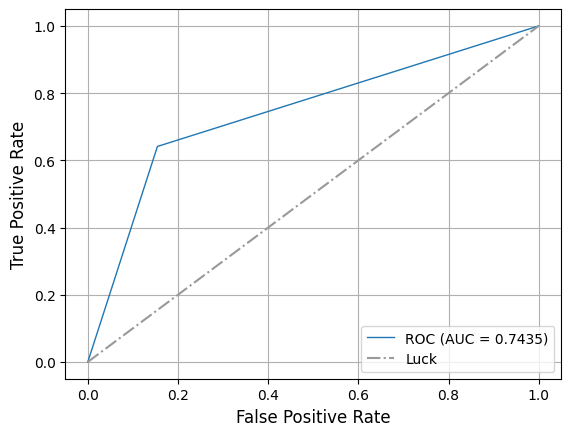

In [43]:
plot_utils.plot_roc(train_test_data[3], score_test);


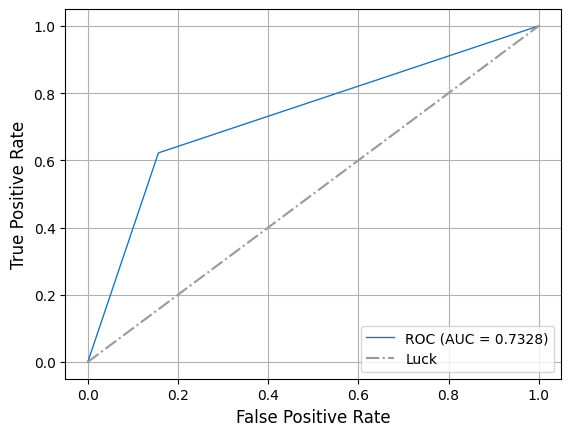

In [44]:
score_train = bnn.predict(train_test_data[0][training_cols])
plot_utils.plot_roc(train_test_data[1], score_train);

In [45]:
hdl_data_pandas=hdl_data.get_data_frame()
hdl_data_tf=tf.convert_to_tensor(hdl_data_pandas, dtype=tf.float32)
predictions=bnn.predict(hdl_data_pandas[training_cols])

full_predictions = bnn.predict(hdl_data_pandas[training_cols])

original_index = hdl_data_pandas.index


full_predictions_df = pd.DataFrame(full_predictions, columns=['Predictions'], index=original_index)


hdl_data_pandas['Predictions'] = full_predictions_df['Predictions']

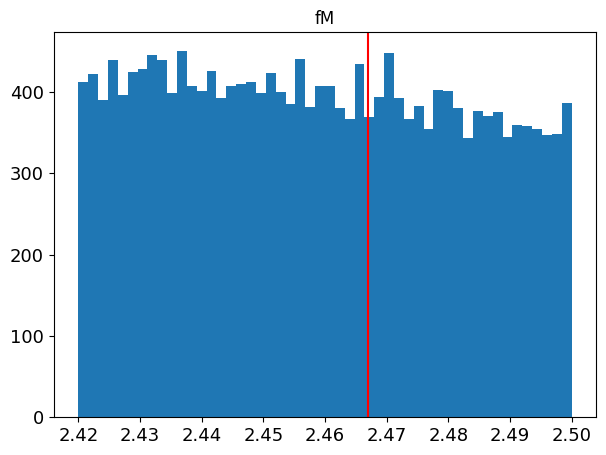

In [46]:
listOfCol=['fM']
cutString='Predictions==1'
hdl_data_pandas.query(cutString).hist(column=listOfCol,figsize=(7,5),xlabelsize=13,ylabelsize=13,grid=0,bins=50,log=0)
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')